**Brian Blaylock**  
**26 February 2019**

# Compute the area of a closed lat/lon path
Source: https://stackoverflow.com/questions/4681737/how-to-calculate-the-area-of-a-polygon-on-the-earths-surface-using-python

--------
## Green's Theorem:
> "Green's theorem can be used to determine the area and centroid of plane figures solely by integrating over the perimeter."

- https://mathinsight.org/greens_theorem_idea
- https://en.wikipedia.org/wiki/Green%27s_theorem#Area_calculation
- https://leancrew.com/all-this/2018/01/greens-theorem-and-section-properties/
- https://math.blogoverflow.com/2014/06/04/greens-theorem-and-area-of-polygons/
- [Some Algorithms for Polygons on a Sphere, JPL](https://trs.jpl.nasa.gov/bitstream/handle/2014/41271/07-0286.pdf?sequence=1&isAllowed=y)

\begin{equation}
\int_C F\cdot ds = \int_C (Ldx + Mdy) = \iint_D \left( \frac{\partial M}{\partial x}  - \frac{\partial L}{\partial y} \right) dx dy 
\end{equation}

Where L and M are a funciton of (x, y), In other words, L and M are the points of a path. Circulation must be counterclockwise.

How does this translate to Python language?

    area=np.abs(0.5*np.sum(ys[:-1]*np.diff(xs)-xs[:-1]*np.diff(ys)))
    
where `xs` and `ys` are the vertices of a closed loop.
    
- Absolute value: so that it doesn't matter if the points are clockwise or counterclockwise, the area is always postivie.


## Use Shapely!
Convert the vertices to a shapely Polygon. The `.area` method gives roughly the same result as computing Green's Theorem ourselves.

---
## Basemap's role
Basemap is used to generate a projection of the latitude/longitude points on a Cylindrial Equal-Area map. The map coordinates, in meters, can be used to compute an area.

Map Type: [Cylindrical Equal Area](http://desktop.arcgis.com/en/arcmap/10.3/guide-books/map-projections/cylindrical-equal-area.htm)
- Shape is true along the standard parallels of the normal aspect. Distortion is severe near the poles of the normal aspect.
- There is no area distortion.

---
---

# HOWEVER!
None of these methods acount for the curvature of the earth. If the area is large enough, the above methods will be an underestimate.

For model datasets, we have to account for the curvature of the earth. A different funciton helps us do that.

Area of polygon on a sphere:
https://github.com/scisco/area

Source of algorithm:
[Some Algorithms for Polygons on a Sphere, JPL](https://trs.jpl.nasa.gov/bitstream/handle/2014/41271/07-0286.pdf?sequence=1&isAllowed=y)

GeoJSON files for different states were retrieved from:
https://github.com/johan/world.geo.json/tree/master/countries/USA


---
---

In [454]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from shapely.geometry import Polygon
import json

import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_maps.my_basemap import draw_HRRR_map, draw_centermap
from BB_HRRR.HRRR_Pando import get_hrrr_latlon

In [455]:
Hlat, Hlon = get_hrrr_latlon(DICT=False)

In [456]:
GeoJSON_Path = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/geojson_area/'

PATH_points = {
    'Colorado':{
        'lon': np.array(json.loads(open(GeoJSON_Path+'CO.geo.json', 'r').read())['features'][0]['geometry']['coordinates'][0])[:,0], 
        'lat': np.array(json.loads(open(GeoJSON_Path+'CO.geo.json', 'r').read())['features'][0]['geometry']['coordinates'][0])[:,1],
        'google area': 104185},
    'Utah':{
        'lon':np.array(json.loads(open(GeoJSON_Path+'UT.geo.json', 'r').read())['features'][0]['geometry']['coordinates'][0])[:,0],
        'lat':np.array(json.loads(open(GeoJSON_Path+'UT.geo.json', 'r').read())['features'][0]['geometry']['coordinates'][0])[:,1],
        'google area': 84899,},
    'CA':{
        'lon':np.array(json.loads(open(GeoJSON_Path+'CA.geo.json', 'r').read())['features'][0]['geometry']['coordinates'][0])[:,0],
        'lat':np.array(json.loads(open(GeoJSON_Path+'CA.geo.json', 'r').read())['features'][0]['geometry']['coordinates'][0])[:,1],
        'google area': 163696},
    'Idaho':{
        'lon':np.array(json.loads(open(GeoJSON_Path+'ID.geo.json', 'r').read())['features'][0]['geometry']['coordinates'][0])[:,0],
        'lat':np.array(json.loads(open(GeoJSON_Path+'ID.geo.json', 'r').read())['features'][0]['geometry']['coordinates'][0])[:,1],
        'google area': 83642},
    'Wyoming':{
        'lon':np.array(json.loads(open(GeoJSON_Path+'WY.geo.json', 'r').read())['features'][0]['geometry']['coordinates'][0])[:,0],
        'lat':np.array(json.loads(open(GeoJSON_Path+'WY.geo.json', 'r').read())['features'][0]['geometry']['coordinates'][0])[:,1],
        'google area': 97818},
    'HRRR':
        {'lon': np.concatenate([Hlon[0], Hlon[:,-1], Hlon[-1][::-1], Hlon[:,0][::-1]]),
         'lat': np.concatenate([Hlat[0], Hlat[:,-1], Hlat[-1][::-1], Hlat[:,0][::-1]]),
         'google area': np.nan},
    'West':{
        'lon':[-120, -104, -104, -120, -120],
        'lat':[24.4, 24.4, 50.2, 50.2, 24.2],
        'google area': np.nan},
    'Central':{
        'lon':[-104, -88, -88, -104, -104],
        'lat':[24.4, 24.4, 50.2, 50.2, 24.2],
        'google area': np.nan},
    'East':{
        'lon':[-88, -72, -72, -88, -88],
        'lat':[24.4, 24.4, 50.2, 50.2, 24.2],
        'google area': np.nan},
}

## Combine lat/lon as vertice pair as a tuple. i.e. (lon, lat).
PATH_verts = {}
for i in PATH_points.keys():
    PATH_verts[i] = list(zip(PATH_points[i]['lon'], PATH_points[i]['lat']))

## Generate Path objects from the vertices.
PATHS = {}
for i in PATH_verts.keys():
    PATHS[i] = Path(PATH_verts[i])

In [458]:
PATHS['HRRR']

Path(array([[-122.72   ,   21.138  ],
       [-122.69333,   21.14499],
       [-122.66666,   21.15197],
       ...,
       [-122.735  ,   21.18775],
       [-122.7275 ,   21.16287],
       [-122.72   ,   21.138  ]]), None)

# Compute Area (two methods)

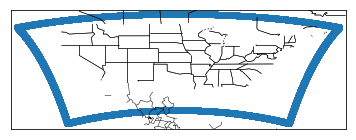

In [459]:
# Get vertices
loc = 'HRRR'
coordinates = PATHS[loc].vertices
lats=coordinates[:,1]
lons=coordinates[:,0]

lat1=np.min(lats)-1.5
lat2=np.max(lats)+1.5
lon1=np.min(lons)-1.5
lon2=np.max(lons)+1.5

# Make a Cylindrial Equal-Area Projection map
bmap = Basemap(projection='cea',llcrnrlat=lat1,llcrnrlon=lon1,urcrnrlat=lat2,urcrnrlon=lon2)
# Convert latitude and longitude points to map coordinates (meters)
xs, ys = bmap(lons,lats)

bmap.scatter(lons, lats, latlon=True);
bmap.drawstates();

### 1) Shapely Method

In [460]:
# Shapely Method
cop = Polygon(zip(xs, ys))
area=cop.area
area_sqmiles = area*0.38610216/1e6
print('Shapely %s: %.2f' % (loc, area_sqmiles), 'sq miles')
print('Diff_from_google: %.2f' % (area_sqmiles-PATH_points[loc]['google area']), 'sq miles')

Shapely HRRR: 6476563.09 sq miles
Diff_from_google: nan sq miles


### 2) Green's Theorem Method

In [461]:
# Green's Theorem Method
area=np.abs(0.5*np.sum(ys[:-1]*np.diff(xs)-xs[:-1]*np.diff(ys)))
area_sqmiles = area*0.38610216/1e6
print("Green's %s: %.2f" % (loc, area_sqmiles), 'sq miles')
print('Diff_from_google: %.2f' % (area_sqmiles-PATH_points[loc]['google area']), 'sq miles')

Green's HRRR: 6476563.09 sq miles
Diff_from_google: nan sq miles


In [462]:
# Google's Size
print(' Google %s : %s sq miles' % (loc, PATH_points[loc]['google area']))

 Google HRRR : nan sq miles


# Compute Area on a Sphere!

In [463]:
from geojson_area.area import area as GeoJSON_area

In [466]:
for loc in ['Utah', 'Colorado', 'CA', 'Idaho', 'Wyoming', 'HRRR', 'West', 'Central', 'East']:
    obj = {'type':'Polygon','coordinates':[list(zip(PATH_points[loc]['lon'], PATH_points[loc]['lat']))]}
    area = GeoJSON_area(obj)
    area_sqmiles = area*0.38610216/1e6
    area_sqkilometers = area*0.38610216/1e6
    print("GeoJSON %s: %.2f" % (loc, area_sqmiles), ' sq miles')
    print('Diff_from_google: %.2f' % (area_sqmiles-PATH_points[loc]['google area']), 'sq miles')
    print()

GeoJSON Utah: 84932.15  sq miles
Diff_from_google: 33.15 sq miles

GeoJSON Colorado: 104211.64  sq miles
Diff_from_google: 26.64 sq miles

GeoJSON CA: 158421.56  sq miles
Diff_from_google: -5274.44 sq miles

GeoJSON Idaho: 83531.19  sq miles
Diff_from_google: -110.81 sq miles

GeoJSON Wyoming: 97883.36  sq miles
Diff_from_google: 65.36 sq miles

GeoJSON HRRR: 6491087.85  sq miles
Diff_from_google: nan sq miles

GeoJSON West: 1557882.37  sq miles
Diff_from_google: nan sq miles

GeoJSON Central: 1557882.37  sq miles
Diff_from_google: nan sq miles

GeoJSON East: 1557882.37  sq miles
Diff_from_google: nan sq miles



Note: California's area is probably way off becuase the geojson file doesn't include the islands and is a lower resolution.

In [453]:
np.shape(obj['coordinates'])

(1, 13, 2)